In [5]:
from simulation import *
from aesthetics import *
from models import *
from data import *

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
mpl.rc('text', usetex=True)

In [7]:
import pandas as pd
import scipy as sc
import os as os
import re as re

# Scan files
## Flux

In [8]:
df = pd.DataFrame()

In [9]:
for file in range(len(unbound_files)):
    name = os.path.splitext(os.path.basename(unbound_files[file]))[0]
    name = re.search('^[^_]*', name).group(0)
    if name == 'chi1CYM185':
        pass
    else:
        this = simulation()
        this.name = name
        this.data_source = 'pka_md_data'
        this.offset_factor = 6.0
        this.D = 3 * 10 ** 12
        this.simulate()
        flux_with_catalysis = np.mean(this.flux_u + this.flux_b)
        flux_with_catalysis_std = np.std(this.flux_u + this.flux_b)
        
        this.simulate(catalysis=False)
        flux_without_catalysis = np.mean(this.flux_u + this.flux_b)
        flux_without_catalysis_std = np.std(this.flux_u + this.flux_b)
  
        df = df.append(pd.DataFrame({'Flux with catalysis': flux_with_catalysis,
                                'Flux with catalysis Std': flux_with_catalysis_std,
                                'Flux without catalysis': flux_without_catalysis,
                                'Flux without catalysis Std': flux_without_catalysis_std,
                                'File': name,
                                'Ratio': flux_with_catalysis / flux_without_catalysis,
                                }, index=[0]), ignore_index=True)

In [10]:
df['Ratio'] = df['Flux with catalysis'] / df['Flux without catalysis']

In [11]:
df.sort_values('Flux with catalysis', ascending=True).head(n=10)

,File,Flux with catalysis,Flux with catalysis Std,Flux without catalysis,Flux without catalysis Std,Ratio
367,chi2GLU194,-51.100489,0.000486,0.000325,0.001033,-157435.385379
193,chi1PHE171,-42.493249,0.003837,0.002052,0.005592,-20713.107773
788,phiGLY273,-35.799374,0.000519,0.000053,0.000403,-674426.881303
186,chi1MET44,-26.322136,0.005082,0.003075,0.003433,-8558.748178
72,chi1GLU194,-24.621773,0.005917,-0.003262,0.002966,7547.564355
1321,psiVAL109,-19.916908,0.000478,-0.000140,0.000250,141917.915323
1325,psiVAL1,-18.497651,0.000551,0.000228,0.000365,-81011.933566
1066,psiASP309,-17.776921,0.000399,-0.000109,0.000410,163570.323797
1118,psiGLY186,-16.339798,0.000415,0.000287,0.000557,-57001.319698
13,chi1ARG42,-14.936352,0.000171,-0.000331,0.000543,45107.796254


## Write flux to files

In [144]:
df['ResID'] = df['File'].str.extract('(\\d+$)')

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [175]:
filename = 'residues-by-flux'
attribute = 'flux'

file = str(filename) + '.dat'
f = open(file, 'w')
f.write('attribute: {}\n'.format(attribute))
f.write('match mode: any\n')
f.write('recipient: residues\n')
    # Loop over the residues
for i in range(1, max(df['ResID'].astype(int))):
    # For each residue, write the flux value that's the greatest...
    x = df[df['ResID'] == str(i)]['Flux with catalysis']
#     if abs(x.min()) > abs(x.max()):
#         value = x.min()
#     else:
#         value = x.max()
    value = max(abs(df[df['ResID'] == str(i)]['Flux with catalysis']))
    f.write('\t:{}\t{}\n'.format(i, value))
f.close()

## Symmetrized data

In [14]:
df_symmetrized_data = pd.DataFrame()
dir = 'reversed-and-averaged'
for file in range(len(unbound_files)):
    name = os.path.splitext(os.path.basename(unbound_files[file]))[0]
    name = re.search('^[^_]*', name).group(0)
    if name == 'chi1CYM185':
        pass
    else:
        this = simulation()
        this.name = name
        # Override the popluations
        this.unbound_population = np.genfromtxt(dir + '/apo/' + name + '_chi_pop_hist_targ.txt', delimiter=',',
                                               skip_header=1)
        this.bound_population = np.genfromtxt(dir + '/atpmg/' + name + '_chi_pop_hist_ref.txt', delimiter=',',
                                               skip_header=1)
        
        this.simulate(pka_md_data=False)
        flux_with_catalysis = np.mean(this.flux_u + this.flux_b)
        flux_with_catalysis_sem = sc.stats.sem(this.flux_u + this.flux_b)
  
        df_symmetrized_data = df_symmetrized_data.append(pd.DataFrame({'Flux with catalysis': flux_with_catalysis,
                                'Flux with catalysis SEM': flux_with_catalysis_sem,
                                }, index=[0]), ignore_index=True)

/home/dslochower/recovery-fund/SG-model-v2/simulation.py:256: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


## Maximum power and efficiency

In [10]:
power_data = pd.DataFrame()
# delta_g = 12 # kcal/mol converted from 20 kT (ish...)
delta_g = -13

def return_negative_power(value, *args):
        this = simulation(data_source='pka_md_data')
        this.load = True
        this.load_slope = value[0]
        this.name = args[0]
        this.simulate()
        power = (this.load_slope)*(np.mean(this.flux_u + this.flux_b))  
        power = -1.0 * power
        print('Load\t{0:0.5f}\tFlux\t{1:0.2f}\tPower\t{2:0.2f}'.format(this.load_slope, np.mean(this.flux_u + this.flux_b),
                                                                    power))

        return power

for file in range(len(pka_unbound_files)):
    name = os.path.splitext(os.path.basename(pka_unbound_files[file]))[0]
    name = re.search('^[^_]*', name).group(0)
    if name == 'chi1CYM185':
        continue
    if name == 'chi1ASP98':
        print('FIX THIS LATER!')
        continue
    
    this = simulation(data_source='pka_md_data')
    this.name = name
    this.simulate()
    flux_with_catalysis = np.mean(this.flux_u + this.flux_b)
    print(name, flux_with_catalysis)
    if flux_with_catalysis > 0:
        positive = True
        guess = 0.001
    else:
        positive = False
        guess = -0.001
    
    result = sc.optimize.fmin(return_negative_power, (guess), args= (name, positive), full_output=True)
    efficiency = result[1] / (delta_g * np.sum(this.catalytic_rate * this.bound_population))
    if result[1] > 0:
        efficiency *= -1
    
    power_data = power_data.append(pd.DataFrame({'Flux with catalysis': flux_with_catalysis,
                'File': name,
                'Max Power': -1.0 * result[1],
                'Load at max power': result[0][0],
                'Efficiency': efficiency,
                }, index=[0]), ignore_index=True)


chi1ARG119 -0.0167104176594
Load	-0.00100	Flux	1.10	Power	0.00
Load	-0.00105	Flux	1.16	Power	0.00
Load	-0.00095	Flux	1.05	Power	0.00
Load	-0.00090	Flux	0.99	Power	0.00
Load	-0.00080	Flux	0.88	Power	0.00
Load	-0.00070	Flux	0.77	Power	0.00
Load	-0.00050	Flux	0.54	Power	0.00
Load	-0.00030	Flux	0.32	Power	0.00
Load	0.00010	Flux	-0.13	Power	0.00
Load	0.00050	Flux	-0.58	Power	0.00
Load	0.00050	Flux	-0.58	Power	0.00
Load	-0.00010	Flux	0.10	Power	0.00
Load	-0.00030	Flux	0.32	Power	0.00
Load	0.00000	Flux	-0.02	Power	0.00
Load	0.00010	Flux	-0.13	Power	0.00
Load	-0.00005	Flux	0.04	Power	0.00
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 16
chi1ARG120 0.000250073547971
Load	0.00100	Flux	-0.23	Power	0.00
Load	0.00105	Flux	-0.24	Power	0.00
Optimization terminated successfully.
         Current function value: 0.000231
         Iterations: 1
         Function evaluations: 2
chi1ARG123 -0.195207866743
Load	-0.00100

In [12]:
power_data.sort_values('Max Power', ascending=False).head()

,Efficiency,File,Flux with catalysis,Load at max power,Max Power
366,0.002457,chi2GLU194,-51.100489,-0.17015,4.471723
32,0.000955,chi1ASP152,24.311549,0.14415,1.737708
71,0.000860,chi1GLU194,-24.621773,-0.12495,1.565068
1320,0.000524,psiVAL109,-19.916908,-0.09495,0.953501
191,0.000373,chi1PHE140,-7.297939,-0.18815,0.678961


In [13]:
total_power = np.sum(power_data['Max Power'])
total_power_ratio = total_power / (delta_g * this.catalytic_rate)
print('{0:11.9f} kcal mol**-1 second**-1 \t{1:11.9f}'.format(total_power, total_power_ratio))

11.534468537 kcal mol**-1 second**-1 	-0.006337620


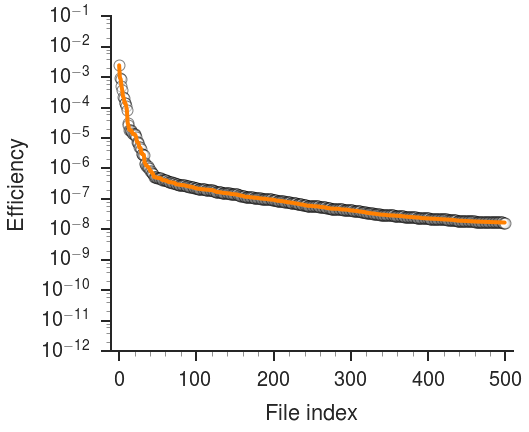

In [60]:
fig = plt.figure(figsize=(6*1.2,6), dpi=300)
ax = fig.add_subplot(111)
aesthetics.paper_plot(fig)
cmap = sns.color_palette("Paired", 10)
ax.scatter(range(500), power_data.sort_values(by = 'Efficiency', ascending=False)['Efficiency'].head(500), 
           s = 120, c ='w', edgecolor = 'k', lw=1, alpha=0.5)
ax.plot(range(500), power_data.sort_values(by = 'Efficiency', ascending=False)['Efficiency'].head(500), 
          lw=4, c = cmap[7])

aesthetics.paper_plot(fig, scientific=False)
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
ax.set_ylim([10**-12, 10**-1])
ax.set_xlim([-10, 510])
ax.set_ylabel('Efficiency')
ax.set_xlabel('File index')
ax.set_yscale('log')

## Efficiency

In [2]:
pass

## Interesting torsions

In [18]:
sum(df[abs(df['Flux with catalysis']) > 1]['Flux with catalysis Std'] < 1)

131

In [12]:
sum(abs(df['Flux with catalysis']) > 1)

131

In [17]:
df[abs(df['Flux with catalysis']) > 1]

,File,Flux with catalysis,Flux with catalysis Std,Flux without catalysis,Flux without catalysis Std,Ratio
4,chi1ARG151,24.136169,0.003552,-0.002362,0.005886,-10216.719345
6,chi1ARG180,4.538159,0.000874,0.000187,0.000221,24220.943979
7,chi1ARG242,-1.092123,0.000427,0.000272,0.000369,-4013.311885
11,chi1ARG31,-3.463198,0.005512,0.002102,0.004096,-1647.901814
12,chi1ARG322,-8.693501,0.000262,-0.000246,0.000437,35355.852150
13,chi1ARG42,-14.936352,0.000171,-0.000331,0.000543,45107.796254
32,chi1ASP152,24.311549,0.001087,0.000218,0.001272,111354.733538
41,chi1ASP27,1.471793,0.000534,0.000709,0.000546,2076.304815
43,chi1ASP309,20.243653,0.000416,0.000174,0.000351,116256.273994
49,chi1CYS329,-3.839037,0.002358,0.004304,0.007345,-891.999069


## Calculate Michaelis constant

In [132]:
michaelis_data = pd.DataFrame()


for file in range(len(pka_unbound_files)):
    name = os.path.splitext(os.path.basename(pka_unbound_files[file]))[0]
    name = re.search('^[^_]*', name).group(0)
    if name == 'chi1CYM185':
        continue
    
    this = simulation(data_source='pka_md_data')
    this.name = name
    this.simulate()
    flux_with_catalysis = np.mean(this.flux_u + this.flux_b)
    bins = this.bins
    
    michaelis = (np.sum(this.C_intersurface * np.exp(-1 * (this.unbound - this.bound) / float(this.kT)) * this.ss[bins:2*bins]) / np.sum(this.ss[bins:2*bins]) + np.sum(this.catalytic_rate * this.ss[bins:2*bins]) / np.sum(this.ss[bins:2*bins])) / (np.sum(this.C_intersurface * this.ss[0:bins]) / np.sum(this.ss[0:bins]))
    print(np.sum(this.C_intersurface * np.exp(-1 * (this.unbound - this.bound) / float(this.kT)) * this.ss[bins:2*bins]))
    print('{0:12.12f}'.format(michaelis))
    michaelis_data = michaelis_data.append(pd.DataFrame({'Flux with catalysis': flux_with_catalysis,
                'File': name,
                'K_M': michaelis,
                'kcat/km' : this.catalytic_rate / michaelis,
                }, index=[0]), ignore_index=True)





8.28991194724
0.000628733266
8.28989600117
0.000628733338
8.28967904425
0.000628733336
8.28991912941
0.000628733270
8.33968895508
0.000629011190
8.28977797581
0.000628733386
8.2899724716
0.000628733507
8.28989093216
0.000628733283
8.28994053684
0.000628733530
8.28981612616
0.000628733275
8.29004245174
0.000628734109
8.2897792279
0.000628734098
8.29012470057
0.000628734311
8.29005982217
0.000628734110
8.28989479324
0.000628733268
8.28958533251
0.000628733263
8.28991254059
0.000628733263
8.28996300694
0.000628733585
8.28989874199
0.000628733275
8.28993675865
0.000628733432
8.28990333564
0.000628733285
8.29015702476
0.000628733602
8.28993276331
0.000628733356
8.28992001773
0.000628733337
8.29024091293
0.000628734899
8.29020014604
0.000628733300
8.28993384518
0.000628733312
8.2898856468
0.000628733332
8.28995886686
0.000628733468
8.2898649326
0.000628733326
8.28991983666
0.000628733269
8.28991554376
0.000628733596
10.3043828769
0.000640007555
8.29010336538
0.000628734246
8.28993451344
0.00

In [3]:
michaelis_data.describe()

NameError: name 'michaelis_data' is not defined

In [16]:
def gaussian(x, *p):
    A, mu, sigma = p
    return A * np.exp(-(x - mu)**2/(2. * sigma**2))

def fit_gaussian(bin_centers, histogram, *p):
    from scipy.optimize import curve_fit
    coefficients, variance = curve_fit(gaussian, bin_centers, histogram, p0=p[0])
    return coefficients, variance